#### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pprint
%matplotlib inline
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from matplotlib import style
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The Original Dataset

In [ ]:
data = pd.read_excel("DatasetBDOS.xlsx", header=3)

In [ ]:
data.head()

,Country,Year,Month,Day,Coverage ratio,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,AT,2006,1,1,100.0,6297.0,6005.0,5743.0,5397.0,5213.0,5190.0,4916.0,5158.0,5405.0,5731.0,6075.0,6385.0,6276.0,6249.0,6247.0,6231.0,6603.0,6979.0,7022.0,6930.0,6560.0,6170.0,6501.0,6168.0
1,AT,2006,1,2,100.0,5900.0,5643.0,5524.0,5372.0,5481.0,5941.0,6459.0,7352.0,7840.0,8107.0,8250.0,8434.0,8312.0,8259.0,8190.0,8168.0,8469.0,8735.0,8617.0,8218.0,7773.0,7247.0,7413.0,6926.0
2,AT,2006,1,3,100.0,6483.0,6192.0,5991.0,5773.0,5849.0,6252.0,6685.0,7480.0,7872.0,8154.0,8292.0,8435.0,8222.0,8150.0,8112.0,8055.0,8342.0,8670.0,8534.0,8203.0,7745.0,7214.0,7397.0,6981.0
3,AT,2006,1,4,100.0,6522.0,6217.0,6027.0,5802.0,5866.0,6289.0,6730.0,7554.0,7947.0,8180.0,8309.0,8241.0,8253.0,8233.0,8145.0,8081.0,8331.0,8470.0,8460.0,8185.0,7759.0,7242.0,7441.0,6981.0
4,AT,2006,1,5,100.0,6575.0,6237.0,6065.0,5841.0,5887.0,6283.0,6704.0,7491.0,7964.0,8202.0,8337.0,8434.0,8240.0,8153.0,8046.0,8042.0,8268.0,8361.0,8453.0,8114.0,7606.0,7139.0,7333.0,6888.0


Filtering Italy Data

In [ ]:
dataset = data[data["Country"]=="IT"].reset_index(drop=True)

In [ ]:
#coverage ratio not needed
dataset = dataset.drop(labels="Coverage ratio",axis=1)

In [ ]:
dataset.head()

,Country,Year,Month,Day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,IT,2006,1,1,27190.0,25782.0,24354.0,23340.0,22786.0,22965.0,23605.0,23880.0,24933.0,26918.0,28748.0,29965.0,29118.0,27513.0,27395.0,27776.0,30763.0,32602.0,33478.0,33536.0,32778.0,31285.0,29275.0,26557.0
1,IT,2006,1,2,24488.0,23050.0,22558.0,22446.0,23259.0,25859.0,30566.0,35043.0,39427.0,41456.0,41975.0,41677.0,39823.0,39785.0,40513.0,41171.0,45000.0,46014.0,45535.0,42869.0,40550.0,37386.0,34061.0,30892.0
2,IT,2006,1,3,28459.0,27217.0,26527.0,26511.0,27125.0,29452.0,34095.0,38914.0,43151.0,44855.0,44732.0,43710.0,41293.0,41441.0,42231.0,42719.0,46119.0,47777.0,46844.0,44512.0,41821.0,38331.0,35128.0,31741.0
3,IT,2006,1,4,29211.0,27713.0,27128.0,27017.0,27557.0,29745.0,34875.0,39798.0,43695.0,45081.0,44932.0,44302.0,41822.0,41633.0,42253.0,43215.0,46366.0,48330.0,47429.0,45069.0,42397.0,39010.0,35760.0,32367.0
4,IT,2006,1,5,29763.0,28210.0,27609.0,27296.0,27888.0,30012.0,34791.0,40252.0,44138.0,45659.0,45260.0,44325.0,41964.0,41807.0,42617.0,43208.0,46196.0,47626.0,46989.0,44375.0,41683.0,38441.0,35304.0,32147.0


Transforming Dataset into useful format and saving it

In [ ]:
dataset = dataset.melt(id_vars=['Country','Year','Month','Day'], var_name='Hour', value_name='EC_MW')

In [ ]:
dataset = dataset.sort_values(['Year','Month','Day'])
dataset = dataset.reset_index(drop=True)
dataset.head()

,Country,Year,Month,Day,Hour,EC_MW
0,IT,2006,1,1,0,27190.0
1,IT,2006,1,1,1,25782.0
2,IT,2006,1,1,2,24354.0
3,IT,2006,1,1,3,23340.0
4,IT,2006,1,1,4,22786.0


In [ ]:
dataset['datetime'] = pd.to_datetime(dataset[['Year', 'Month', 'Day','Hour']], format = '%Y/%M/%D %H')

In [ ]:
dataset = dataset.drop(labels=['Country','Year','Month','Day','Hour'],axis=1)

In [ ]:
cols = ['datetime','EC_MW']
dataset = dataset[cols]
dataset.head()

,datetime,EC_MW
0,2006-01-01 00:00:00,27190.0
1,2006-01-01 01:00:00,25782.0
2,2006-01-01 02:00:00,24354.0
3,2006-01-01 03:00:00,23340.0
4,2006-01-01 04:00:00,22786.0


In [ ]:
#Save point
dataset.to_csv("dataset.csv",index=None)

Removing Null values


In [ ]:
df = pd.read_csv('dataset.csv')

In [ ]:
df.head()

,datetime,EC_MW
0,2006-01-01 00:00:00,27190.0
1,2006-01-01 01:00:00,25782.0
2,2006-01-01 02:00:00,24354.0
3,2006-01-01 03:00:00,23340.0
4,2006-01-01 04:00:00,22786.0


In [ ]:
df.isnull().sum()

datetime     0
EC_MW       10
dtype: int64

In [ ]:
df = df.interpolate()

In [ ]:
df.isnull().sum()

datetime    0
EC_MW       0
dtype: int64

#### Exploratory Data Analysis

In [ ]:
df.head()

,datetime,EC_MW
0,2006-01-01 00:00:00,27190.0
1,2006-01-01 01:00:00,25782.0
2,2006-01-01 02:00:00,24354.0
3,2006-01-01 03:00:00,23340.0
4,2006-01-01 04:00:00,22786.0


In [ ]:
dataset = df
dataset["Month"] = pd.to_datetime(df["datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["datetime"]).dt.date
dataset["Time"] = pd.to_datetime(df["datetime"]).dt.time
dataset["Week"] = pd.to_datetime(df["datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(df["datetime"]).dt.day_name()
dataset['Q'] = pd.to_datetime(df['datetime']).dt.quarter
#dataset = df.set_index("datetime")
#dataset.index = pd.to_datetime(dataset.index)
dataset = dataset.set_index("datetime")
dataset.head(1)


,EC_MW,Month,Year,Date,Time,Week,Day,Q
datetime,,,,,,,,
2006-01-01 00:00:00,27190.0,1,2006,2006-01-01,00:00:00,52,Sunday,1


In [ ]:
# How many Unique Year do we Have in Dataset 
print(df.Year.unique(),"\n")
print("Total Number of Unique Year", df.Year.nunique(), "\n")

[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015] 

Total Number of Unique Year 10 



In [ ]:
lab=['12AM','1AM','2AM','3AM','4AM','5AM','6AM','7AM','8AM','9AM',
            '10AM','11AM','12PM', '1PM','2PM','3PM','4PM','5PM','6PM','7PM',
            '8PM','9PM','10PM',"11PM"]

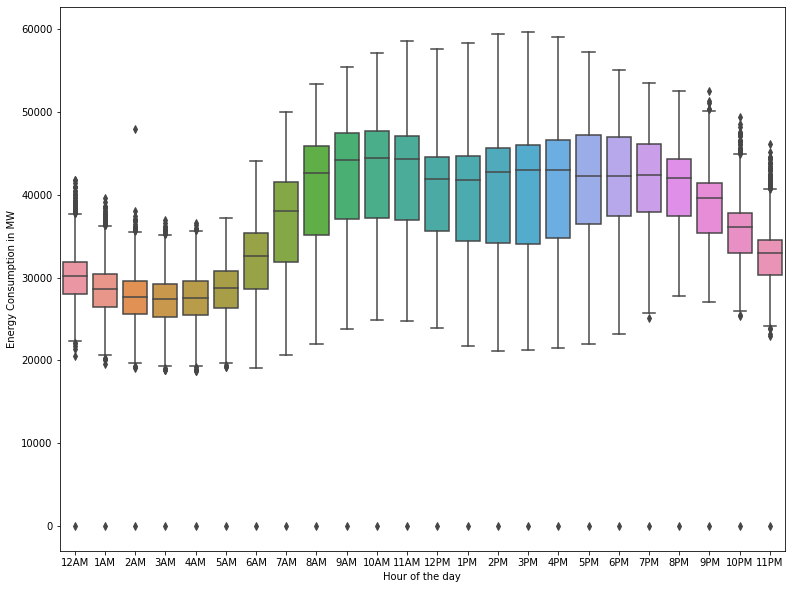

In [ ]:
fig, ax = plt.subplots(figsize=(13, 10)) 
dayplot = sns.boxplot(x=df['Time'], y=df.EC_MW)
dayplot.set(ylabel='Energy Consumption in MW',xlabel='Hour of the day')
labs = dayplot.set_xticklabels(lab)

[Text(0, 0.5, 'Energy Consumption in MW'), Text(0.5, 0, 'Day of the Week')]

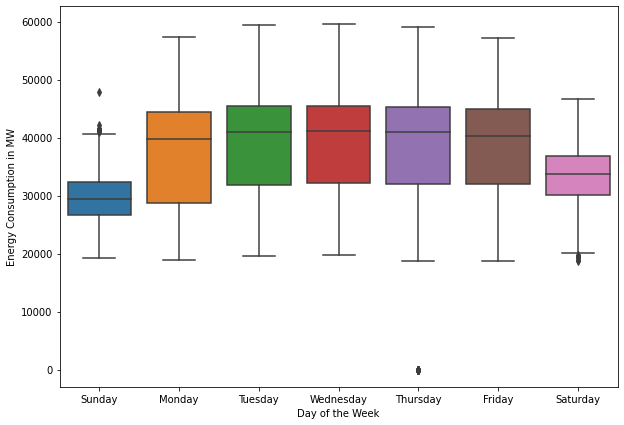

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7)) 
weekplot = sns.boxplot(x=df['Day'], y=df.EC_MW)
weekplot.set(ylabel='Energy Consumption in MW',xlabel='Day of the Week')


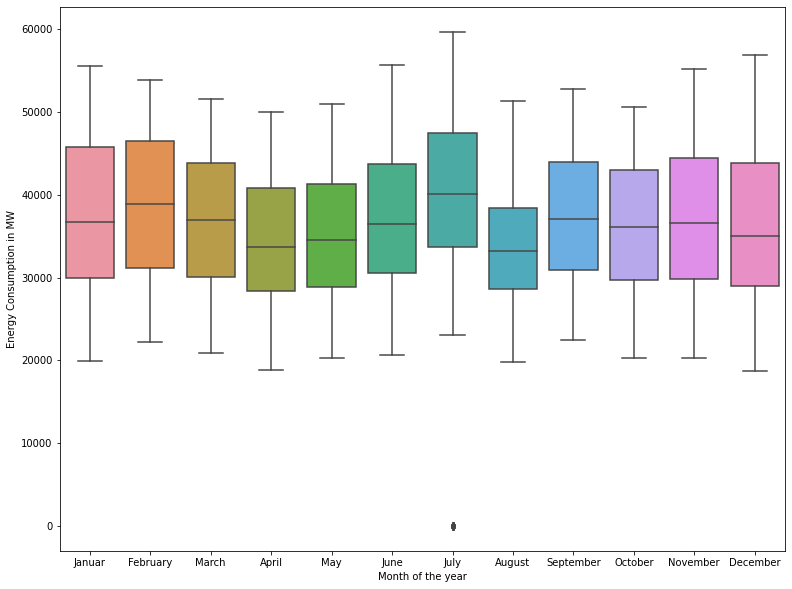

In [ ]:
l = ['Januar','February','March','April','May','June','July','August','September','October','November','December']
fig, ax = plt.subplots(figsize=(13, 10)) 
monthplot = sns.boxplot(x=df['Month'], y=df.EC_MW)
monthplot.set(ylabel='Energy Consumption in MW',xlabel='Month of the year')
lab = monthplot.set_xticklabels(l)

Text(0, 0.5, 'Energy in MW')

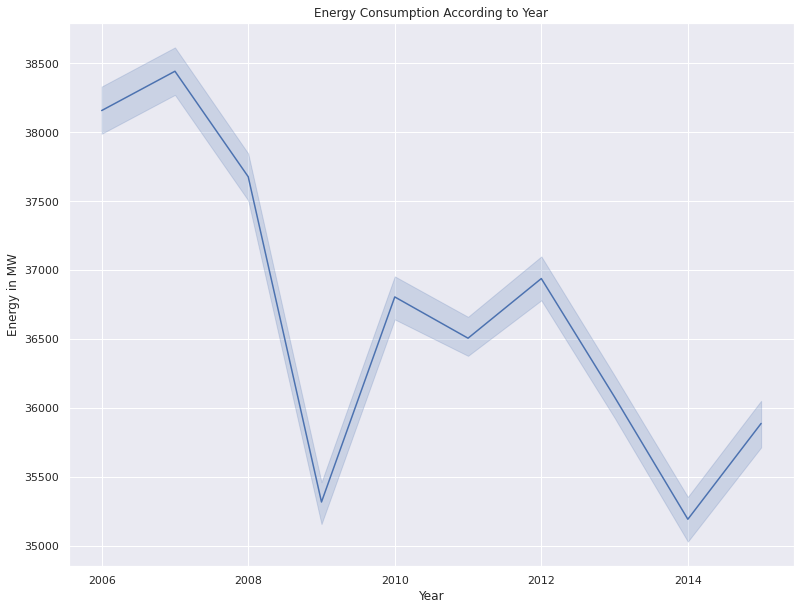

In [ ]:


fig, ax1 = plt.subplots(figsize=(13, 10)) 


yearplot = sns.lineplot(x=dataset["Year"], y=dataset["EC_MW"], data=df)

plt.title("Energy Consumption According to Year")
plt.xlabel("Year")
plt.ylabel("Energy in MW")


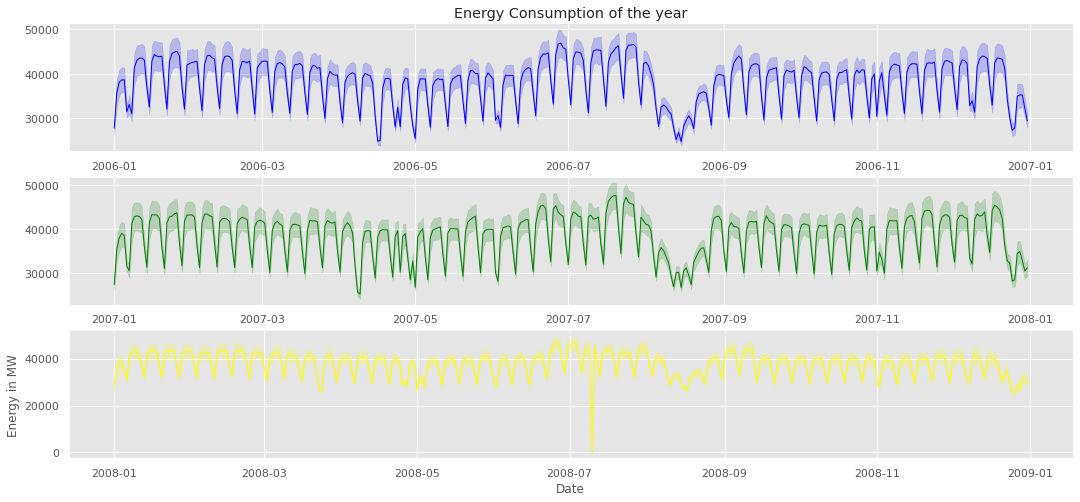

In [ ]:
from matplotlib import style


fig = plt.figure()

ax1= fig.add_subplot(311)
ax2= fig.add_subplot(312)
ax3= fig.add_subplot(313)


style.use('ggplot')

y_2006 = dataset[dataset['Year']==2006]["EC_MW"].to_list()
x_2006 = dataset[dataset['Year']==2006]["Date"].to_list()
plot2006 = sns.lineplot(x=x_2006,y=y_2006, color="blue", linewidth=1,ax=ax1,legend=2006)


y_2007 = dataset[dataset['Year']==2007]["EC_MW"].to_list()
x_2007 = dataset[dataset['Year']==2007]["Date"].to_list()
plot2007=sns.lineplot(x=x_2007, y=y_2007, color="green", linewidth=1,ax=ax2,legend=2007)


y_2008 = dataset[dataset['Year']==2008]["EC_MW"].to_list()
x_2008 = dataset[dataset['Year']==2008]["Date"].to_list()
plot2008=sns.lineplot(x= x_2008,y=y_2008, color="yellow", linewidth=1,ax=ax3,legend=2008)

plt.rcParams["figure.figsize"] = (18,8)
d=plot2006.set_title( "Energy Consumption of the year")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True, alpha=1)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Ennergy Distribution')

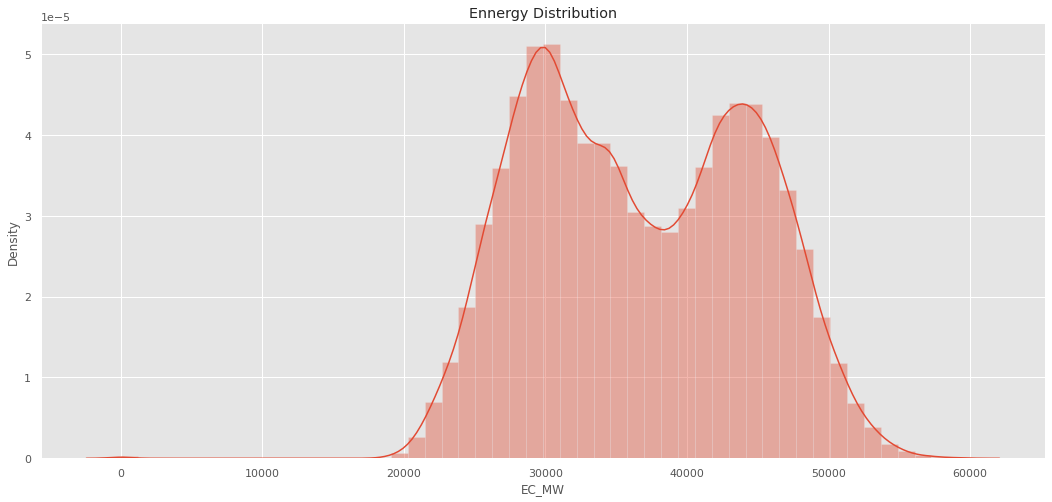

In [ ]:
distribution =sns.distplot(dataset["EC_MW"])
distribution =plt.title("Energy Distribution")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

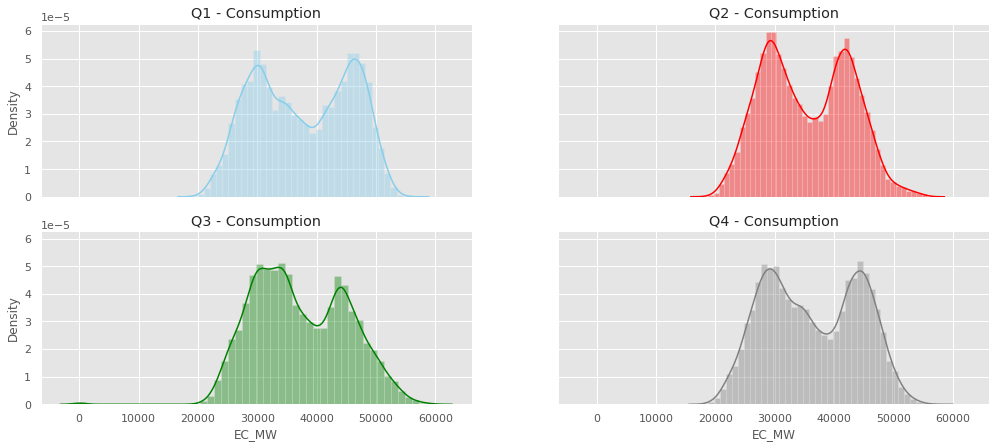

In [ ]:
#Data prep
Q1 = dataset[dataset["Q"]==1]
Q2 = dataset[dataset["Q"]==2]
Q3 = dataset[dataset["Q"]==3]
Q4 = dataset[dataset["Q"]==4]

#Plot
fig,axes = plt.subplots(2,2,figsize=(17,7),sharex=True,sharey=True)

sns.distplot(Q1["EC_MW"],color="skyblue", ax=axes[0,0]).set_title("Q1 - Consumption")
sns.distplot(Q2["EC_MW"],color="red", ax=axes[0,1]).set_title("Q2 - Consumption")
sns.distplot(Q3["EC_MW"],color="green", ax=axes[1,0]).set_title("Q3 - Consumption")
sns.distplot(Q4["EC_MW"],color="gray", ax=axes[1,1]).set_title("Q4 - Consumption")

del Q1, Q2, Q3, Q4

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87648 entries, 0 to 87647
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  87648 non-null  object 
 1   EC_MW     87638 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.3+ MB


In [4]:
df.isnull().sum()

datetime     0
EC_MW       10
dtype: int64

In [5]:
df1= df.interpolate()

In [6]:
df1.isnull().sum()

datetime    0
EC_MW       0
dtype: int64

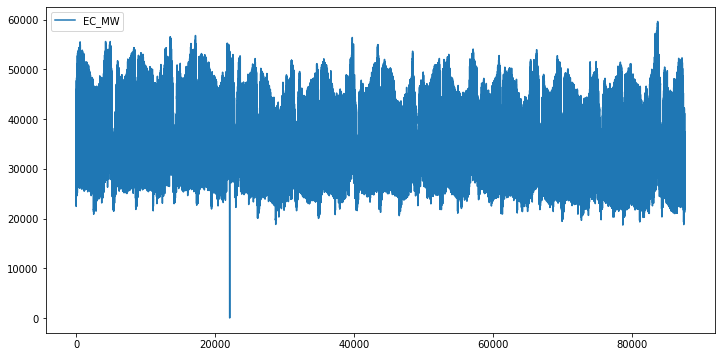

In [ ]:
df1.plot(figsize=(12,6))

#### Feature Engineering

In [7]:
df1['datetime'] = pd.to_datetime(df1['datetime'])

In [8]:
df1 = df1.set_index('datetime')

In [ ]:
results  = seasonal_decompose(df1['EC_MW'])

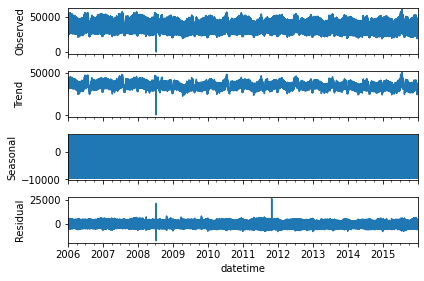

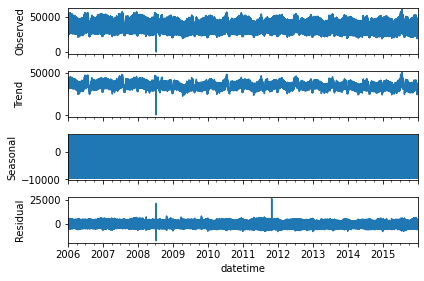

In [ ]:
results.plot()

Test, Train, validation split

In [9]:
len(df1)

87648

In [10]:
train = df1.iloc[:61368]
val = df1.iloc[61368:70128]
test = df1.iloc[70128:]

In [11]:

scaler = MinMaxScaler()

Normalizing data

In [12]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

In [52]:
train.head(10)

,EC_MW
datetime,
2006-01-01 00:00:00,27190.0
2006-01-01 01:00:00,25782.0
2006-01-01 02:00:00,24354.0
2006-01-01 03:00:00,23340.0
2006-01-01 04:00:00,22786.0
2006-01-01 05:00:00,22965.0
2006-01-01 06:00:00,23605.0
2006-01-01 07:00:00,23880.0
2006-01-01 08:00:00,24933.0


In [51]:
scaled_train[:10]

array([[0.47851184],
       [0.45373271],
       [0.4286016 ],
       [0.4107564 ],
       [0.40100665],
       [0.40415684],
       [0.41542008],
       [0.42025976],
       [0.43879131],
       [0.47372497]])

In [14]:
scaled_test[:10]

array([[0.44394777],
       [0.42585618],
       [0.40118264],
       [0.37856816],
       [0.36565063],
       [0.3645595 ],
       [0.37710746],
       [0.38228151],
       [0.38717398],
       [0.41776073]])

In [15]:
scaled_val[:10]

array([[0.47735032],
       [0.45755165],
       [0.43235015],
       [0.41124916],
       [0.39500546],
       [0.39349196],
       [0.40436803],
       [0.40730703],
       [0.40908451],
       [0.4345852 ]])

Creating Time steps of 7 day of history to look back in datasets Train, Val, Test

In [16]:
X_Train = []
Y_Train = []

# Range should be fromm 168 Values to END 
for i in range(168, scaled_train.shape[0]):
    
    # X_Train 0-59 
    X_Train.append(scaled_train[i-168:i])
    
    # Y Would be 168 th Value based on past 168 Values 
    Y_Train.append(scaled_train[i])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(61200, 168, 1)
(61200, 1)


In [17]:
X_Val = []
Y_Val = []

# Range should be fromm 168 Values to END 
for i in range(168, scaled_val.shape[0]):
    
    # X_Val 0-59 
    X_Val.append(scaled_val[i-168:i])
    
    # Y Would be 168 th Value based on past 168 Values 
    Y_Val.append(scaled_val[i])

# Convert into Numpy Array
X_Val = np.array(X_Val)
Y_Val = np.array(Y_Val)

print(X_Val.shape)
print(Y_Val.shape)

(8592, 168, 1)
(8592, 1)


In [18]:
X_Test = []
Y_Test = []

# Range should be fromm 168 Values to END 
for i in range(168, scaled_test.shape[0]):
    
    # X_Test 0-167 
    X_Test.append(scaled_test[i-168:i])
    
    # Y Would be 168 th Value based on past 168 Values 
    Y_Test.append(scaled_test[i])

# Convert into Numpy Array
X_Test = np.array(X_Test)
Y_Test = np.array(Y_Test)

print(X_Test.shape)
print(Y_Test.shape)

(17352, 168, 1)
(17352, 1)


#### First Model-RNN model Long Short Term Memory

In [ ]:
regressor = keras.models.Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(layers.LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1],1)))
regressor.add(layers.Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(layers.LSTM(units = 50, return_sequences = True))
regressor.add(layers.Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(layers.LSTM(units = 50, return_sequences = True))
regressor.add(layers.Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(layers.LSTM(units = 50))
regressor.add(layers.Dropout(0.2))

# Adding the output layer
regressor.add(layers.Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 168, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 168, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 168, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 168, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 168, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 168, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [ ]:
regressor.fit(X_Train,Y_Train, validation_data=(X_Val,Y_Val), epochs = 50, batch_size = 32)

Epoch 1/50
1913/1913 [==============================] - 59s 25ms/step - loss: 0.0098 - val_loss: 0.0017
Epoch 2/50
1913/1913 [==============================] - 47s 24ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 3/50
1913/1913 [==============================] - 47s 25ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 4/50
1913/1913 [==============================] - 47s 25ms/step - loss: 0.0012 - val_loss: 7.1809e-04
Epoch 5/50
1913/1913 [==============================] - 47s 24ms/step - loss: 9.2534e-04 - val_loss: 4.8642e-04
Epoch 6/50
1913/1913 [==============================] - 47s 24ms/step - loss: 7.8440e-04 - val_loss: 2.7939e-04
Epoch 7/50
1913/1913 [==============================] - 47s 24ms/step - loss: 6.3489e-04 - val_loss: 2.8694e-04
Epoch 8/50
1913/1913 [==============================] - 47s 24ms/step - loss: 5.5224e-04 - val_loss: 1.9802e-04
Epoch 9/50
1913/1913 [==============================] - 47s 24ms/step - loss: 5.0816e-04 - val_loss: 1.6437e-04
Epoch 10/50
1913/191

In [ ]:
regressor.save("regressor.h5")

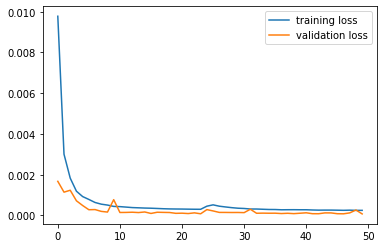

In [ ]:
loss_per_epoch = regressor.history.history['loss']
val_loss = regressor.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.plot(range(len(val_loss)), val_loss)
plt.legend(['training loss','validation loss'])

In [ ]:
predicted_EC = regressor.predict(X_Test)

# Do inverse Transformation to get Values 
predicted_EC = scaler.inverse_transform(predicted_EC)

In [ ]:
predicted_EC[:10]

array([[29420.957],
       [27385.639],
       [26569.645],
       [26246.697],
       [26625.37 ],
       [27961.896],
       [33292.293],
       [39994.336],
       [45256.945],
       [47366.58 ]], dtype=float32)

In [ ]:
True_EC = scaler.inverse_transform(Y_Test)
Pred_EC  = predicted_EC
dates = df1.iloc[70296:].index.to_list()

In [ ]:
print("Evaluate on test data")
eresult = regressor.evaluate(X_Test, Y_Test, batch_size=32)
print("test loss, test acc:", eresult)

Evaluate on test data
543/543 [==============================] - 6s 11ms/step - loss: 1.0049e-04
test loss, test acc: 0.00010048918920801952


In [ ]:
test_score = r2_score(True_EC, Pred_EC)
print('Test R2 Score: %.3f' % test_score)

Test R2 Score: 0.995


In [ ]:
print("RMSE = ",np.sqrt(mean_squared_error))

RMSE =  569.6083158307334


#### Prediction Using First Model

No handles with labels found to put in legend.


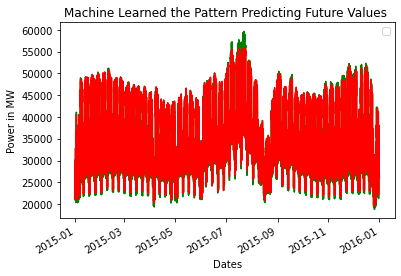

In [ ]:
fig = plt.figure()

ax1= fig.add_subplot(111)

x = dates[-8760:]
y = True_EC[-8760:]

y1 = Pred_EC[-8760:]

plt.plot(x,y, color="green")
plt.plot(x,y1, color="red")
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.xlabel('Dates')
plt.ylabel("Power in MW")
plt.title("Machine Learned the Pattern Predicting Future Values of the Year 2015 ")
plt.legend()

In [ ]:
future = pd.DataFrame({"Date":dates,"Predicted":[x[0] for x in list(predicted_EC)], "True":[x[0] for x in list(True_EC)]})

In [ ]:
future = future.set_index('Date')
future.tail(10)

,Predicted,True
Date,,
2015-12-31 14:00:00,32050.220703,31803.0
2015-12-31 15:00:00,32080.921875,31993.0
2015-12-31 16:00:00,33288.234375,33302.0
2015-12-31 17:00:00,37392.558594,37388.0
2015-12-31 18:00:00,38049.527344,37424.0
2015-12-31 19:00:00,36797.488281,36038.0
2015-12-31 20:00:00,34502.636719,32808.0
2015-12-31 21:00:00,31443.298828,29633.0
2015-12-31 22:00:00,28408.443359,27461.0


### Second Model - A Bidirectional LSTM 

In [19]:

model = keras.models.Sequential()
model.add(
  layers.Bidirectional(
    layers.LSTM(
      units=128, 
      input_shape=(X_Train.shape[1], X_Train.shape[2])
    )
  )
)
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               133120    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_________________________________________________________________


In [20]:
history_model= model.fit(
    X_Train, Y_Train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False,
    validation_data = (X_Val,Y_Val)
)

Epoch 1/30
1722/1722 [==============================] - 39s 17ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 2/30
1722/1722 [==============================] - 29s 17ms/step - loss: 0.0019 - val_loss: 6.9221e-04
Epoch 3/30
1722/1722 [==============================] - 29s 17ms/step - loss: 0.0013 - val_loss: 4.7678e-04
Epoch 4/30
1722/1722 [==============================] - 29s 17ms/step - loss: 0.0010 - val_loss: 3.7563e-04
Epoch 5/30
1722/1722 [==============================] - 29s 17ms/step - loss: 8.4188e-04 - val_loss: 3.2876e-04
Epoch 6/30
1722/1722 [==============================] - 29s 17ms/step - loss: 7.7899e-04 - val_loss: 3.3277e-04
Epoch 7/30
1722/1722 [==============================] - 29s 17ms/step - loss: 6.7360e-04 - val_loss: 2.8070e-04
Epoch 8/30
1722/1722 [==============================] - 29s 17ms/step - loss: 5.8183e-04 - val_loss: 2.6493e-04
Epoch 9/30
1722/1722 [==============================] - 29s 17ms/step - loss: 5.1024e-04 - val_loss: 2.6108e-04
Epoch 10/30


In [21]:
model.save('model2.h5')

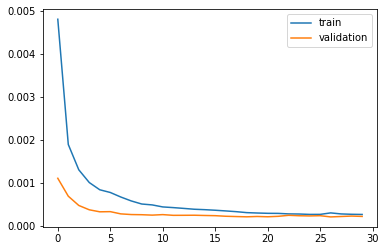

In [22]:
plt.plot(history_model.history['loss'], label='train')
plt.plot(history_model.history['val_loss'], label='validation')
plt.legend();

In [24]:
P = model.predict(X_Test)

# Do inverse Transformation to get Values 
P = scaler.inverse_transform(P)

In [27]:
True_EC = scaler.inverse_transform(Y_Test)
dates = df1.iloc[70296:].index.to_list()

In [25]:
print("Evaluate on test data")
m = model.evaluate(X_Test, Y_Test, batch_size=32)
print("test loss, test acc:", m)

Evaluate on test data
543/543 [==============================] - 4s 8ms/step - loss: 2.7386e-04
test loss, test acc: 0.0002738584589678794


In [28]:
test_score = r2_score(True_EC, P)
print('Test R2 Score: %.3f' % test_score)

Test R2 Score: 0.986


In [38]:
print("RMSE = ",np.sqrt(mean_squared_error(True_EC,P)))

RMSE =  940.3284650504146


#### Prediction using model 2

No handles with labels found to put in legend.


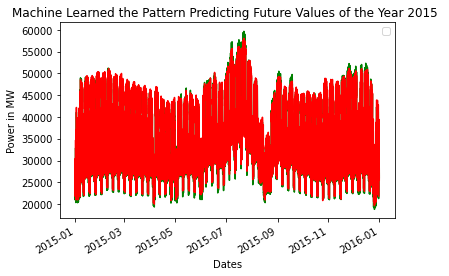

In [40]:
fig = plt.figure()

ax1= fig.add_subplot(111)

x = dates[-8760:]
y = True_EC[-8760:]

y1 = P[-8760:]

plt.plot(x,y, color="green")
plt.plot(x,y1, color="red")
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.xlabel('Dates')
plt.ylabel("Power in MW")
plt.title("Machine Learned the Pattern Predicting Future Values of the Year 2015 ")
plt.legend()

In [41]:
future = pd.DataFrame({"Date":dates,"Predicted":[x[0] for x in list(P)], "True":[x[0] for x in list(True_EC)]})
future = future.set_index('Date')
future.tail(10)

,Predicted,True
Date,,
2015-12-31 14:00:00,31903.996094,31803.0
2015-12-31 15:00:00,32444.074219,31993.0
2015-12-31 16:00:00,33173.492188,33302.0
2015-12-31 17:00:00,34411.675781,37388.0
2015-12-31 18:00:00,39400.382812,37424.0
2015-12-31 19:00:00,39190.507812,36038.0
2015-12-31 20:00:00,36067.824219,32808.0
2015-12-31 21:00:00,29826.248047,29633.0
2015-12-31 22:00:00,26765.734375,27461.0


#### Feature Engineering Explained 
*Not Important*

In [ ]:
DF = pd.read_csv("dataset.csv")
date_time = pd.to_datetime(DF.pop('datetime'), format='%Y.%m.%d %H:%M:%S')
DF.head()

,EC_MW
0,27190.0
1,25782.0
2,24354.0
3,23340.0
4,22786.0


Importance of Time Stamp how it can be used in Timeseries analaysis as signal

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [ ]:
day = 24*60*60
year = (365.2425)*day
DF['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
DF['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
DF['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
DF['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

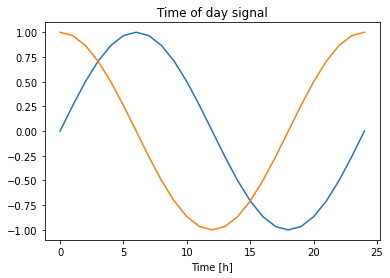

In [ ]:
plt.plot(np.array(DF['Day sin'])[:25])
plt.plot(np.array(DF['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Importance of Normalizing data so that Neural Network can understand Better

In [ ]:
column_indices = {name: i for i, name in enumerate(DF.columns)}

n = len(DF)
train_DF = DF[0:int(n*0.7)]
val_DF = DF[int(n*0.7):int(n*0.9)]
test_DF = DF[int(n*0.9):]

num_features = DF.shape[1]

In [ ]:
train_mean = train_DF.mean()
train_std = train_DF.std()

train_DF = (train_DF - train_mean) / train_std
val_DF = (val_DF - train_mean) / train_std
test_DF = (test_DF - train_mean) / train_std

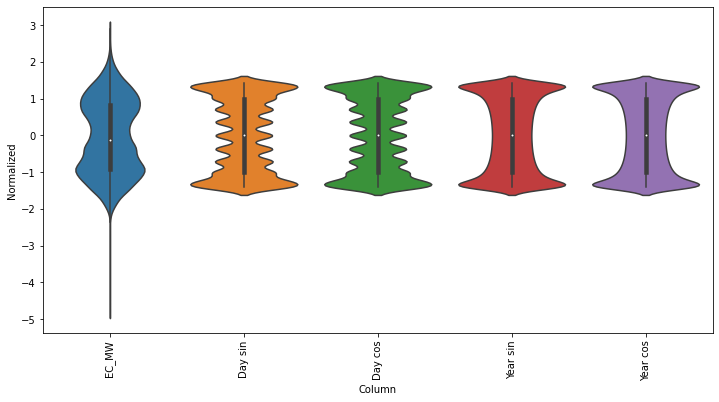

In [ ]:
DF_std = (DF - train_mean) / train_std
DF_std = DF_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=DF_std)
_ = ax.set_xticklabels(DF.keys(), rotation=90)